# Final Project
There are different simulation models for polymers: all-atom model, united-atom model and coarse-grained model. All-atom model has good performance but is time consuming. By grouping different numbers of atoms into a single bead, we can save computational cost but may sacrifice the accuracy. We tried all three kinds of models on polypropylene and calculated their radius of gyration (Rg) for comparison. 

I used the packages from this website: https://github.com/coarse-graining/cgnet. If you want to try some CGnet machine learning things, please refer to the initial code and go through the examples in the example folder. If you want to go through my codes in the coarse-grained model part, please download the package and set up the environment according to its instruction.

In [1]:
import numpy as np
import torch.nn as nn
import torch

from cgnet.feature import (GeometryFeature, GeometryStatistics,
                           MoleculeDataset, LinearLayer)
from cgnet.network import (CGnet, HarmonicLayer, ForceLoss, ZscoreLayer,
                           lipschitz_projection, dataset_loss, Simulation)

import mdtraj as md
from cgnet.molecule import CGMolecule

from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
%matplotlib inline

# We specify the CPU as the training/simulating device here.
# If you have machine  with a GPU, you can use the GPU for
# accelerated training/simulation by specifying 
# device = torch.device('cuda')
device = torch.device('cpu')

# All-atom model
I used OPLS all-atom model to simulate PP in water. tip4p.itp water model is used. I simulated the system for 20 ns with gromacs package. I have an output every 1 ps. All the data are included in the FPdata/PPAT. With the gromacs command in run.sh file, I ran the simulation and obtained the Rg data.

In [2]:
F = open('FPdata/PPAA/rg.xvg', 'r')
rg=[]
begin = 0
with open('FPdata/PPAA/rg.xvg', 'r') as F:
    for line in F:
        P = line.split()
        if P[0] == '10000.000':
            begin = 1
        if begin == 1:
            rg.append([float(P[0]),float(P[3])])
RgAA=np.array(rg)

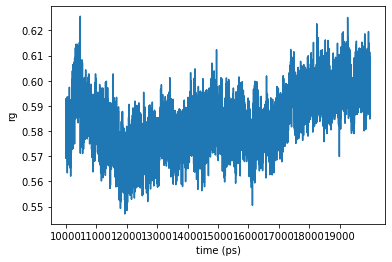

In [3]:
fig = plt.figure()
plt.plot(RgAA[:,0],RgAA[:,1], label='All atom Rg')
plt.xlabel("time (ps)")
plt.xticks(np.arange(10000,20000,1000))
plt.ylabel("rg")
plt.show()

# United-atom model
I used TraPP-UA model to simulate PP in water. tip4p.itp water model is used. I simulated the system for 10 ns with gromacs package. I have an output every 1 ps. All the data are included in the FPdata/PPUT. With the gromacs command in run.sh file, I ran the simulation and obtained the Rg data.

In [4]:
F = open('FPdata/PPUA/rg.xvg', 'r')
rg=[]
begin = 0
with open('FPdata/PPUA/rg.xvg', 'r') as F:
    for line in F:
        P = line.split()
        if P[0] == '0.000':
            begin = 1
        if begin == 1:
            rg.append([float(P[0]),float(P[3])])
RgUA=np.array(rg)

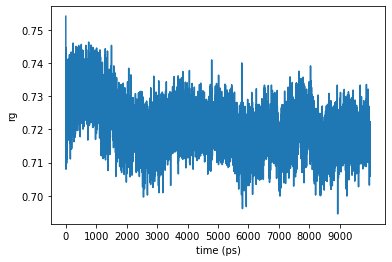

In [5]:
fig = plt.figure()
plt.plot(RgUA[:,0],RgUA[:,1], label='All atom Rg')
plt.xlabel("time (ps)")
plt.xticks(np.arange(0,10000,1000))
plt.ylabel("rg")
plt.show()

The Rg obtained by the TraPP-UA model is slighly higher than that obtained by the OPLS model. The TraPP-UA model may not be suitable for this system.

# Coarse-grained model
I want to try some coarse-grained models for polymers. There is some research about how to use coarse-grained model to study polymers: https://pubs.acs.org/doi/10.1021/acsomega.0c05321. There are different Machine-Learned CG Models. Due to time limitation, I only tried CGnet, which is a well-developped model.

I used the data from the all atom simulation. The 10,000 data points are spaced at 1 picosecond intervals for a total of 20 nanoseconds of simulation time. The coordinates in CG10_trj.gro and force in force10.xvg are gengerated from GROMACS directly.

In [6]:
F = open('FPdata/dataPP10/CG10_trj.gro', 'r')
frame = []
frames = []
count = 0
with open('FPdata/dataPP10/CG10_trj.gro') as F:
    for line in F:
        P = line.split()
        if P[0] == '1LIG':
            x = float(P[3])
            y = float(P[4])
            z = float(P[5])
            frame.append([x,y,z])
        if P[0] == 'PP':
            count = count + 1
            if count > 1:
                frames.append(frame)
            frame = []
    frames.append(frame)

In [7]:
F = open('FPdata/dataPP10/force10.xvg', 'r')
frameforce = []
framesforce = []
count = 0
with open('FPdata/dataPP10/force10.xvg') as F:
    for line in F:
        P = line.split()
        if P[0] == '0':
            begin = 1
        if begin == 1:
            for i in range(10):
                frameforce.append([float(P[3*i+1]),float(P[3*i + 2]),float(P[3*i + 3])])
            framesforce.append(frameforce)
            frameforce=[]

In [8]:
coords=np.array(frames,dtype='float32')
forces=np.array(framesforce,dtype='float32')

Check the dimensions of the initial data sets:

In [9]:
print("Coordinates size: {}".format(coords.shape))
print("Force: {}".format(forces.shape))

ala_data = MoleculeDataset(coords, forces, device=device)
print("Dataset length: {}".format(len(ala_data)))

Coordinates size: (20001, 10, 3)
Force: (20001, 10, 3)
Dataset length: 20001


Visualize some frames:

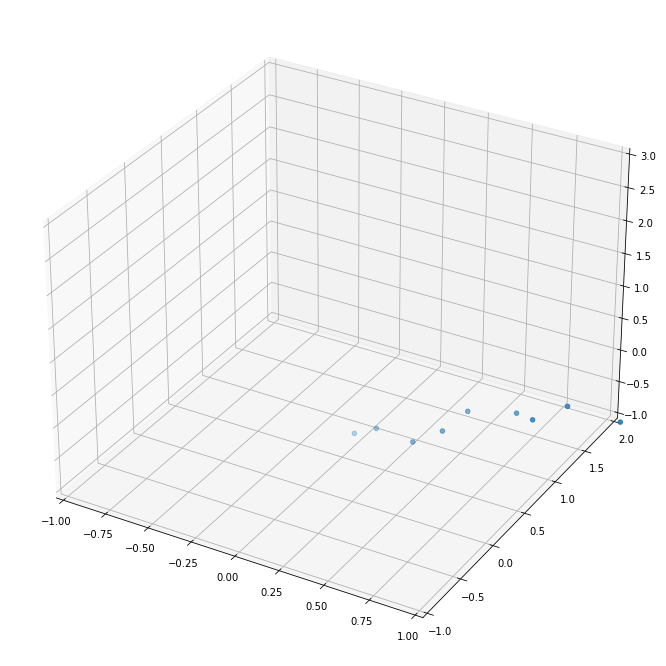

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
i=1000
ax.scatter(coords[i,:,0],coords[i,:,1],coords[i,:,2])
ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=2) 
ax.axes.set_zlim3d(bottom=-1, top=3)
j=0

## Gathering statistics

The harmonic contributions to the free energy from bonds and angles provide an important regularizing prior form on the energy learned by CGnet. Thus, we need to gather some statistics about our data's features. Specifically, we need the `get_bond_constants` method in the `GeometryStatistics` class.

First, we gather statistics specifically for bonds and angles, respectively. Using the `as_list` argument, we can get lists of statistics dictionaries that can be used to construct important prior energies for our CGnet model.

Note that _lists_ contain values, _keys_ contain tuples that specify a feature (e.g., a distance or an angle), and _indices_ contain integers used to locate certain features within _list_ or _key_ objects.

If we look at the dictionaries contained inside the _list_ objects, we see that the means, standard deviations, and harmonic constants are stored according to a tuple containing the bead indices (not the same as the _indices_ above!) of the involved atoms.

In [12]:
stats = GeometryStatistics(coords, backbone_inds='all',
                           get_all_distances=True,
                           get_backbone_angles=True,
                           get_backbone_dihedrals=True)

bond_list, bond_keys = stats.get_prior_statistics(features='Bonds', as_list=True)
bond_indices = stats.return_indices('Bonds')

angle_list, angle_keys = stats.get_prior_statistics(features='Angles', as_list=True)
angle_indices = stats.return_indices('Angles')

#dihedral_list, dihedral_keys = stats.get_prior_statistics(features='dihedrals', as_list=True)
#dihedral_indices = stats.return_indices('Dihedrals')
print("We have {} backbone beads, {} bonds, and {} angles.".format(
                        coords.shape[1], len(bond_list), len(angle_list)))
print("Bonds: ")
for key, stat in zip(bond_keys, bond_list):
    print("{} : {}".format(key, stat))
print("Angles: ")
for key, stat in zip(angle_keys, angle_list):
    print("{} : {}".format(key, stat))
#print("Dihedrals: ")
#for key, stat in zip(dihedral_keys, dihedral_list):
 #   print("{} : {}".format(key, stat))

We have 10 backbone beads, 9 bonds, and 8 angles.
Bonds: 
(0, 1) : {'mean': tensor(0.2608), 'std': tensor(0.0051), 'k': tensor(22743.0820)}
(1, 2) : {'mean': tensor(0.2657), 'std': tensor(0.0048), 'k': tensor(25422.3672)}
(2, 3) : {'mean': tensor(0.2611), 'std': tensor(0.0052), 'k': tensor(22017.1797)}
(3, 4) : {'mean': tensor(0.2649), 'std': tensor(0.0052), 'k': tensor(21842.0332)}
(4, 5) : {'mean': tensor(0.2607), 'std': tensor(0.0052), 'k': tensor(22097.5430)}
(5, 6) : {'mean': tensor(0.2665), 'std': tensor(0.0049), 'k': tensor(25204.6465)}
(6, 7) : {'mean': tensor(0.2624), 'std': tensor(0.0052), 'k': tensor(21657.0410)}
(7, 8) : {'mean': tensor(0.2630), 'std': tensor(0.0050), 'k': tensor(23391.9121)}
(8, 9) : {'mean': tensor(0.2592), 'std': tensor(0.0053), 'k': tensor(21273.0410)}
Angles: 
(0, 1, 2) : {'mean': tensor(2.3096), 'std': tensor(0.1320), 'k': tensor(34.2240)}
(1, 2, 3) : {'mean': tensor(2.1165), 'std': tensor(0.2313), 'k': tensor(11.1395)}
(2, 3, 4) : {'mean': tensor(2.3

In addition to the harmonic constants for the bonds and angles, we want the zscores for every feature, including the dihedrals and the non-bond (i.e., non-adjacent) pairwise distances. Such zscore normalization is useful in speeding up convergence of CGnet parameters during training:

In [13]:
all_stats, _ = stats.get_prior_statistics(as_list=True)
num_feats = len(all_stats)
zscores, _ = stats.get_zscore_array()
print("We have {} statistics for {} features.".format(zscores.shape[0], zscores.shape[1]))

We have 2 statistics for 67 features.


## Hyperparameters

Next, we determine hyperparameters. Following the original paper [1], we use:

* 5 layers with 160 nodes each and tanh activation,
* random sampling from the dataset with a batch size of 512,
* Adam optimization with an intial learning rate of 0.003
* epochal multiplicative learning rate decay with decay constant $\gamma=0.3$, and
* L2 Lipschitz regularization via spectral normalization ($\lambda=4.0$) of each weight matrix.

In [14]:
# Hyperparameters

n_layers = 5
n_nodes = 160
lipschitz_strength = 4.0
activation = nn.Tanh()
batch_size = 512
learning_rate = 0.003
rate_decay = 0.3
lipschitz_strength = 4.0

## Setting up our network architecture and training

Now we are ready to start designing the architecture of our CGnet. We follow the optimal architecture in the CGnet paper [1], which consists of:

- a feature layer that outputs pairwise distances, angles, and dihedral angles from the Cartesian input trajectory that subtracts the means and divides by the standard deviations,
- hidden linear layers (bias term inclusive) with the first three followed by nonlinear activation, and
- harmonic prior layers that compute prior energies from bonds and angles.

The layers are stored in the list `layers` and the priors are stored in the list `priors`.

<img src="./figs/CGnet.png" width=600px>

In [15]:
# Start by scaling according to mean and standard deviation
layers = [ZscoreLayer(zscores)]

# The first hidden layer goes from number of features to 160
num_feat = len(all_stats)
layers += LinearLayer(num_feat, n_nodes, activation=activation)

# The inner hidden layers stay the same size
for _ in range(n_layers - 1):
    layers += LinearLayer(n_nodes, n_nodes, activation=activation)

# The last layer produces a single value
layers += LinearLayer(n_nodes, 1, activation=None)

# Construct prior energy layers
priors  = [HarmonicLayer(bond_indices, bond_list)]
priors += [HarmonicLayer(angle_indices, angle_list)]

For the feature layer, we create an instance of `GeometryFeature()`, which provides differentiable transformations from cartesian coordinate inputs into the CGnet to roto-translationally invariant internal features, such as angles, pairwise distances, and dihedrals (in fact, any set of general features can be passed to a `GeometryFeature()` initialization as a list of tuples of beads involved in the interaction).

By default, `GeometryFeature()` featurizes cartesian inputs into pairwise distances, angles, dihedral cosines, and dihedral sines. To make sure that any statistics used for priors or other preprocessing remain consistent with the ouput of the feature layer, the `stats.feature_tuples` attribute can be passed as an argument to `GeometryFeature()`.

In [16]:
feature_layer = GeometryFeature(feature_tuples=stats.feature_tuples, device=device)

With our architecture, we are ready to build our CGnet. Because we are recovering the coarse grain potential by matching the potential of mean force (PMF) from the all-atom + solvent model of alanine dipeptide, we imbue our network with the `ForceLoss()` criterion. We can look at our network by printing the object.

In [17]:
ala2_net = CGnet(layers, ForceLoss(),
                 feature=feature_layer,
                 priors=priors).to(device)
print(ala2_net)

CGnet(
  (arch): Sequential(
    (0): ZscoreLayer()
    (1): Linear(in_features=67, out_features=160, bias=True)
    (2): Tanh()
    (3): Linear(in_features=160, out_features=160, bias=True)
    (4): Tanh()
    (5): Linear(in_features=160, out_features=160, bias=True)
    (6): Tanh()
    (7): Linear(in_features=160, out_features=160, bias=True)
    (8): Tanh()
    (9): Linear(in_features=160, out_features=160, bias=True)
    (10): Tanh()
    (11): Linear(in_features=160, out_features=1, bias=True)
  )
  (priors): Sequential(
    (0): HarmonicLayer()
    (1): HarmonicLayer()
  )
  (criterion): ForceLoss()
  (feature): GeometryFeature()
)


Now we set up our training tools. We will neglect cross-validation for brevity, but this is __not__ acceptable for real analysis. To do cross-validation, a `testloader` would be needed with validation data.

In [18]:
# Training tools

trainloader = DataLoader(ala_data, sampler=RandomSampler(ala_data),
                         batch_size=batch_size)
optimizer = torch.optim.Adam(ala2_net.parameters(),
                             lr=learning_rate)
def regularizer(model, strength=lipschitz_strength):
        lipschitz_projection(model, strength=strength)
scheduler = MultiStepLR(optimizer,milestones=[1,2,3,4,5],
                        gamma=rate_decay)

num_epochs = 5
save_model = True
directory = '.' # to save model

epochal_train_losses = []
epochal_test_losses  = []
verbose = True
batch_freq = 10
epoch_freq = 1

## Train the model!

Now we can train the model.

In [19]:
for epoch in range(1, num_epochs+1):
    test_loss = 0.00
    train_loss = dataset_loss(ala2_net, trainloader,
                              optimizer, regularizer,
                              verbose_interval=batch_freq)
        
    # test_loss = dataset_loss(ala2_net, train_loader)

    if verbose:
        if epoch % epoch_freq == 0:
            print(
                 "Epoch: {} | Train loss: {:.2f} | Test loss: {:.2f}\n".format(
                  epoch, train_loss, test_loss))
        epochal_train_losses.append(train_loss)
        #epochal_test_losses.append(test_loss)

    scheduler.step()
        
if save_model:
    torch.save(ala2_net,"{}/ala2_net.pt".format(directory))

Batch: 10, Loss: 666455.81
Batch: 20, Loss: 650910.31
Batch: 30, Loss: 656088.56
Batch: 40, Loss: 665447.50
Epoch: 1 | Train loss: 661107.43 | Test loss: 0.00

Batch: 10, Loss: 658867.31
Batch: 20, Loss: 621600.12
Batch: 30, Loss: 641175.00
Batch: 40, Loss: 631495.62
Epoch: 2 | Train loss: 648370.24 | Test loss: 0.00

Batch: 10, Loss: 641557.62
Batch: 20, Loss: 647382.25
Batch: 30, Loss: 649931.88
Batch: 40, Loss: 675919.06
Epoch: 3 | Train loss: 644532.65 | Test loss: 0.00

Batch: 10, Loss: 640705.25
Batch: 20, Loss: 648431.75
Batch: 30, Loss: 648580.62
Batch: 40, Loss: 658575.44
Epoch: 4 | Train loss: 643502.70 | Test loss: 0.00

Batch: 10, Loss: 644754.38
Batch: 20, Loss: 647721.69
Batch: 30, Loss: 643238.94
Batch: 40, Loss: 677519.81
Epoch: 5 | Train loss: 643157.79 | Test loss: 0.00



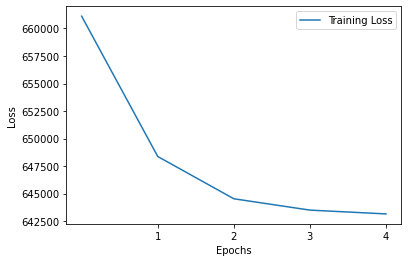

In [20]:
fig = plt.figure()
plt.plot(np.arange(0,len(epochal_train_losses),1),
         epochal_train_losses, label='Training Loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.xticks(np.arange(1,5))
plt.ylabel("Loss")
plt.show()

## Using the coarse-grained force field to simulate system dynamics

First we set up initial coordinates which will be used as the starting points for independent simulations.

We will run 1000 independent simulations seeded evenly the original dataset for 1000 timesteps each. These paramters can be changed below.

In [21]:
n_sims = 1000
n_timesteps = 1000
save_interval = 10

In [22]:
initial_coords = np.concatenate([coords[i].reshape(-1,10,3)
                                 for i in np.arange(0, 10000, 10000//n_sims)],
                                 axis=0)
initial_coords = torch.tensor(initial_coords, requires_grad=True).to(device)
print("Produced {} initial coordinates.".format(len(initial_coords)))

sim = Simulation(ala2_net, initial_coords, length=n_timesteps,
                 save_interval=save_interval, beta=stats.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj = sim.simulate()

Produced 1000 initial coordinates.
Generating 1000 simulations of length 1000 saved at 10-step intervals (Sat Mar 12 12:17:49 2022)


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/cgnet-0.1-py3.7.egg/cgnet/network/simulation.py:257: UserWarning: model  is in training mode, and certain PyTorch layers, such as BatchNorm1d, behave differently in training mode in ways that can negatively bias simulations. We recommend that you put the model into inference mode by calling `model.eval()`.


ValueError: Nan found in dihedral sines. Check your coordinates!)

Due to time limitation, I still cannot fix this bug here. I have tried different coarse-grained methods by varying the atoms grouped in one bead but the bug still exists. One possible reason for this is that the data set is not large enough, so the model is not well trained. Although I did not get good results, it is interesting to learn about the application of machine learning in polymer science. I really appreciate that! 